#  Parameter estimation for binary black holes
This tutorial has been adapted from [Tutorial 3.2](https://github.com/gw-odw/odw-2021/blob/master/Tutorials/Day_3/Tuto_3.2_Parameter_estimation_for_compact_object_mergers.ipynb) of the GW Open Data Workshop \#4

Previously we saw how we can find black hole merger signals in data using the matched filtering technique. While we can get a rough estimate of the masses and other parameters of the system using matched filtering, we are interested in obtaining more accurate and precise statistical statements about the system's properties. This can be done using the framework of **Bayesian parameter estimation**. This technique can be applied to pretty much any situation were you want to fit a model to some data. In this case, our "model" is the gravitational waveform, and the data is the LIGO strain. 

## Bayes' Theorem
Parameter estimation is based on **Bayes' Theorem**, which can be written mathematically as follows:
$$ p(A | B) = \frac{p(B | A)p(A)}{p(B)}$$
What does this actually mean? Bayes' Theorem states that the probability of A given B equals the probability of B given A times the probability of A divided by the probability of B. Let's see an example.

You want to know the probability of there being an accident if there is a lot of traffic on the road. Accidents are rare, $p(\mathrm{accident}) = 0.07$, but traffic is fairly common due to rush hour, $p(\mathrm{traffic}) = 0.35$. The probability of there being traffic when there is an accident is very high (almost always unless it's the middle of the night, for example), $p(\mathrm{traffic} | \mathrm{accident}) = 0.95$. What is $p(\mathrm{accident} | \mathrm{traffic})$? Use the statement of Bayes' Theorem above. What does this probability physically represent? For more examples, check out [this link](https://www.mathsisfun.com/data/bayes-theorem.html).

## Parameter estimation for gravitational waves

In the gravitational-wave case, we are interested in obtaining the probability that our observed event has some parameters, $\theta$, given that we have observed data $d$. Mathematically, we want $p(\theta | d)$, which is called the **posterior probability distribution**. Here $\theta$ is an ensemble of parameters like the masses and distance to the source. There are actually 15 parameters needed to full characterize a binary black hole merger, but for demonstration purposes, we'll just estimate the masses, distance, and time of the merger, $\theta = \{m_{1}, m_{2}, d_{L}, t_{c}\}$.

### Likelihood
What are the components that we need to get $p(\theta | d)$? First, we need $p(d | \theta)$. This is called the **likelihood** of the data. We learned previously that LIGO data are Gaussian. This means that the likelihood is also a Gaussian distribution!
$$p(d | \theta) \propto \exp{\left(-\frac{|d_{f}-h_{f}(\theta)|^{2}}{2\left(\sqrt{\mathrm{PSD}_{f}T/4}\right)^{2}}\right)}$$
Compare this to the general form of the Gaussian we saw in the previous notebook:
$$p(x) \propto \exp{\bigg(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\bigg)}$$
Can you identify what $\mu$ and $\sigma$ are in the likelihood? $d_{f}$ is the frequency-domain representation of the data, $h_{f}(\theta)$ is the frequency-domain representation of the waveform, which depends on the parameters $\theta$, $\mathrm{PSD}_{f}$ is the PSD, and $T$ is the duration of the data being analyzed.

### Prior
Next, we need the prior robability of the parameters, $p(\theta)$. This is our best guess for the masses, distance, etc. for the merger we will analyze before we look at the data. We typically assume we don't know much about these parameters, so we use uninformative priors. For example, we don't expect black holes with mass less than about five times the mass of the sun or greater than ~ 60 times the mass of the sun to form from stellar collapse, but we don't know what the mass should be within that range. For our prior on mass, we can use: 
$$p(m_{1}, m_{2}) = \begin{cases} \mathrm{constant}, & 5 \leq m \leq 60 M_{\odot}\\
0, & \mathrm{otherwise} \end{cases} $$
This means there is an equal chance of the black holes being 25 times the mass of the sun as there is of them being 45 times the mass of the sun.

### Evidence
The last component is the probability of the data, $p(d)$. This is called the **evidence**. It turns out that this is just a normalization factor that is not required to obtain estimates of the parameters $\theta$, so we will ignore this term for now.

Now let's set up these various components for the first gravitational-wave event that we already identified with matched filtering, GW150914. We will use a software called [bilby](https://lscsoft.docs.ligo.org/bilby/) to obtain $p(\theta | d)$.

In [1]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite==6.66' 'bilby==1.0.1' 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, Constraint
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

## Getting the data: GW150914

In this notebook, we'll analyse GW150914. Our first task is to obtain some data! We will use the same tools we used on the first day, namely the `gwpy` package.

We need to know the trigger time. This is the time of the event as identified by the matched filter search. It can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), or we could consult the previous notebook to see where we found it with PyCBC. Here we'll just define it as a variable.

In [3]:
time_of_event = 1126259462.4

### Set up empty interferometers

We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livingston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are `bilby` objects that are used to store the strain data, similar to the `TimeSeries` objects we worked with previously. They are empty in the sense that they don't have any strain data yet, but they know about the orientation and location of their respective namesake detectors. 

In [4]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

### Download the data

To analyse the signal, we need to download analyis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/) and look back to the notebook titled ["working with LIGO data"](https://github.com/asb5468/warrior_scholars/blob/master/working_with_LIGO_data.ipynb).

To analyse GW150914, we will use a 4s segment centered on the event itself. It is standard to choose the segment such that it always includes 2 seconds of data after the trigger. We call this extra 2 seconds the `post_trigger_duration`. We therefore define all times relative to the trigger time, duration, and this post-trigger duration. The segment start time is therefore 2 seconds before the trigger time.

In [5]:
# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

Here, `H1_analysis_data` and its L1 counterpart are gwpy `TimeSeries` objects. As such, we can plot the data itself:

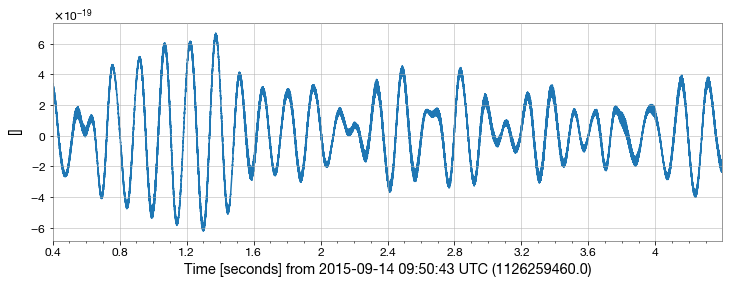

In [6]:
H1_analysis_data.plot()
plt.show()

This doesn't tell us much of course! It is dominated by the low frequency noise.

### Initialise the bilby inteferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` bilby inteferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods in bilby.

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

### Calculate the PSD

As we saw above, parameter estimation relies on having a power spectral density (PSD) - an estimate of the  noise properties of the data. Here, we will create a PSD using data from before our analysis segment. This is done to ensure that the PSD is calculated using pure noise, as it can be affected by the presence of the signal.

Again, we need to download this extra data from the open data server. We start by figuring out the amount of data needed - in this case 32 times the analysis duration. We fetch the segment with this duration immediately preceding the analysis segment.

In [8]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable sets the shape of the tukey window that is applied to the the time-domain data (see the ["working with LIGO data notebook"](https://github.com/asb5468/warrior_scholars/blob/master/working_with_LIGO_data.ipynb) for a refresher on windows).

In [9]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

### Initialise the PSD
Now that we have PSDs for H1 and L1, we can set the `power_spectal_density` attribute of our interferometers with the PSDs we have just calculated above.

In [10]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

### Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongside the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

17:34 bilby INFO    : Generating frequency domain strain from given time domain strain.
17:34 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


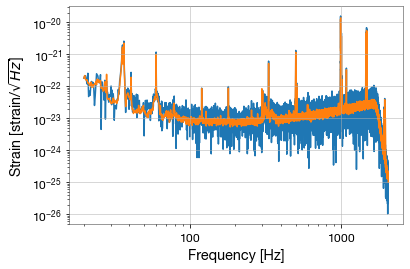

In [11]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artifact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsampled from 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [12]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

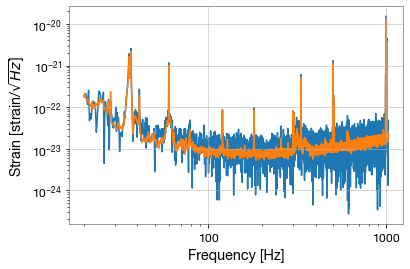

In [13]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

Okay, that is better - we now won't analyse any data near to the artifact produced by downsampling. Now we have some sensible data to analyse so let's go on to doing the analysis!

### Create a prior

Here, we create a prior on the two mass parameters, the `geocent_time`, and a parameter called the `phase`. Similar to the phase we learned about in the first notebook, this parameter basically just sets the alignement of the waveform. We use uniform priors, like the example given above for mass, on all these parameters. We set all the other parameters to fixed values; we'll add the estimation of the distance in the challenge question. 

In [14]:
prior = bilby.core.prior.PriorDict()
prior['mass_1'] = Uniform(name='mass_1', minimum=20,maximum=50)
prior['mass_2'] = Uniform(name='mass_2', minimum=10, maximum=40)
prior['mass_ratio'] = Constraint(name='mass_ratio', minimum=0.1, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

## Create a likelihood

Now we need to set up our likelihood. Bilby already has a built-in implementation of the Gaussian likelihood written above. We just need to initialize a `GravitationalWaveTransient` likelihood object, and bilby will know what to do with it. We need to pass the likelihood components identified in the expression above when we initialize this object, namely the `Interferometer` objects we defined previously with the data and the PSD, and the choice of waveform model to use for $h_{f}(\theta)$. Here we will use an approximant called "IMRPhenomPv2". We create a `WaveformGenerator` object to calculate the model, similar to the PyCBC function we used in previous notebooks.

In [15]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

17:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) the posterior probability for these marginalized parameters.

### Run the analysis

Now that the prior and likelihood are set up (with the data and the signal model), we are ready to obtain our parameter estimates. However, it is very computationally expensive to evaluate the likelihood across the whole prior range that we want to explore. Instead, we will use an algorithm called **nested sampling** to draw samples from the **posterior probability**, $p(\theta | d)$. This was similar to how we simulated test scores from the Gaussian distribution in the [Gaussianity notebook](https://github.com/asb5468/warrior_scholars/blob/master/gaussianity.ipynb). 

In this case, $\mu$ is a complicated function of many parameters, and we have four parameters (two masses, the time, and the phase) that we are trying to sample in rather than just one (test scores). Becasue of these extra complications, we rely on nested sampling to evaluate the likelihood and prior and draw posterior samples for us. In the next cell, we run this algorithm. It will take a few minutes to get the result, even with this reduced parameter space.

In [16]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="rwalk", nact=1, walks=1, nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

17:34 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
17:34 bilby INFO    : Using lal version 7.1.2
17:34 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.2;Id: c21902de2364e911fab0c5fa47ea5b954fbced73;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:34 bilby INFO    : Using lalsimulation version 2.5.1
17:34 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v2.5.1;Id: bdbbfabd0f14ce7fcb8d574f1a07e911e62c85b5;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:34 bilby INFO    : Search parameters:
17:34 bilby INFO    :   mass_1 = Uniform(minimum=20, maximum=50, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
17:34 bilby INFO    :   mass_2 = Uniform(minimum=10, maximum=40, name='mass_2', latex_label='$m_2$', unit=None, boundary=None)
17:34 bilby INFO    :   time_jitter = Uniform(minimum=-0.00024414

0it [00:00, ?it/s]

17:35 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 1, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fec38fee7c0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 1}
17:35 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:35 bilby INFO    : Using dynesty version 1.0.1
17:35 bilby INFO    : Using the bilby-implemented rwalk sample m

2066it [00:00, 18029.36it/s, bound:5 nc:  1 ncall:2.0e+04 eff:10.5% logz-ratio=263.92+/-0.13 dlogz:2.991>3]

17:35 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:35 bilby INFO    : Writing 200 current samples to short/GW150914_samples.dat


2066it [00:02, 880.22it/s, bound:5 nc:  1 ncall:2.0e+04 eff:13.1% logz-ratio=265.91+/-0.14 dlogz:0.005>3]  

17:35 bilby INFO    : Sampling time: 0:01:46.785325
17:35 bilby INFO    : Reconstructing marginalised parameters.




100%|██████████| 2566/2566 [01:02<00:00, 41.31it/s]

17:36 bilby INFO    : Generating sky frame parameters.



100%|██████████| 2566/2566 [00:00<00:00, 4526.67it/s]


17:36 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 2566/2566 [00:09<00:00, 280.47it/s]


17:36 bilby INFO    : Summary of results:
nsamples: 2566
ln_noise_evidence: -8534.562
ln_evidence: -8268.647 +/-  0.143
ln_bayes_factor: 265.914 +/-  0.143



### Looking at the outputs

The `run_sampler` command returned `result_short` - this is a Bilby `Result` object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet). We can use the built-in `plot_corner` function to visualize our posteriors:

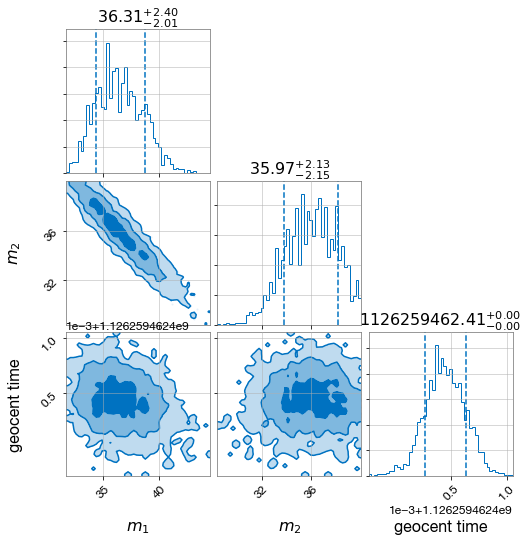

In [17]:
result_short.plot_corner(parameters=['mass_1', 'mass_2', 'geocent_time'])

This is a **corner plot** showing the probability of three of our parameters (we have left out the phase since it's not very interesting). The diagonal shows a histogram of the samples for each individual parameter, and the other grids show the probability density in two dimensions. The darker the color, the higher the probability in that region. The numbers printed on top of each histogram represent the median and uncertainty in each of those parameters. How do those values compare to the template mass we used and time we found for GW150914 in the [matched filtering notebook](https://github.com/asb5468/warrior_scholars/blob/master/matched_filtering_real_data.ipynb)?

## Challenge question
Let's expand on this example a bit. Rerun the analysis above but change the prior on the distance from a fixed value to `bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')`. This will take a bit longer than the original run, around ~20 minutes. You also need to change the `label` in the call to `run_sampler` to avoid over-writing your results.

What is the median reported value of the distance posterior? Don't be alarmed if your results do not match the official LIGO results, which you can see in Fig. 2 [here](https://arxiv.org/pdf/1602.03840.pdf), as these are not rigorous settings.